# Crimes in San Francisco and Seattle show time occurence profiles specific to each city.

In this notebook, I explore Summmer 2014 crime data for San Francisco and Seattle with the goal of identifying meaningful patterns within or between the cities. In the analysis below, I show that the top five crimes in each city exhibit uncanny city-specific time occurence profiles. I believe these profiles should be interpreted skeptically.

### Import useful libraries and the data sets

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

In [2]:
sanfran = pd.read_csv('sanfrancisco_incidents_summer_2014.csv', parse_dates=[['Date','Time']])
seattle = pd.read_csv('seattle_incidents_summer_2014.csv')

/Users/cathiclose/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Index the provided timestamp data, and filter out dates after 08/30/2014 from the Seattle data

In [3]:
sf_ind = pd.DatetimeIndex(sanfran.Date_Time)
sea_ind = pd.DatetimeIndex(seattle['Date Reported'])

In [4]:
seattle = seattle.loc[sea_ind<= '08/31/2014 11:59:00 PM']
sea_ind = sea_ind[sea_ind<= '08/31/2014 11:59:00 PM']

### Create pivot tables aggregating incident counts at different granularities

In [5]:
by_date_sf = sanfran.pivot_table('IncidntNum', aggfunc='count', index=sf_ind.date, columns='Descript')
by_day_sf = sanfran.pivot_table('IncidntNum', aggfunc='count', index=sf_ind.dayofweek, columns='Descript')
by_hr_sf = sanfran.pivot_table('IncidntNum', aggfunc='count', index=sf_ind.hour, columns='Descript')

by_date_sea = seattle.pivot_table('RMS CDW ID', aggfunc='count', index=sea_ind.date, 
                                  columns='Summarized Offense Description')
by_day_sea = seattle.pivot_table('RMS CDW ID', aggfunc='count', index=sea_ind.dayofweek, 
                                 columns='Summarized Offense Description')
by_hr_sea = seattle.pivot_table('RMS CDW ID', aggfunc='count', index=sea_ind.hour,
                                columns='Summarized Offense Description')

### Plot each type of crime incidence for San Francisco and observe for any notable patterns

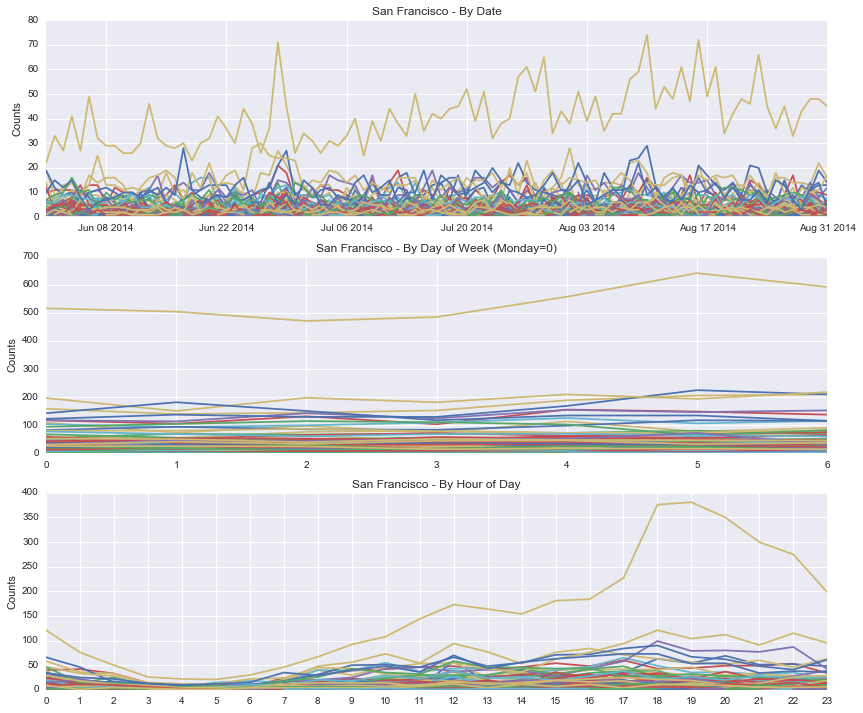

In [6]:
# Plot San Francisco crimes by date, day of week and hour of day
fig, ax = plt.subplots(3,1,figsize=(14,12))
for i, table in enumerate([by_date_sf, by_day_sf, by_hr_sf]):
    if i==0:
        ax[i].set_title('San Francisco - By Date')
    if i==1:
        ax[i].set_title('San Francisco - By Day of Week (Monday=0)')
        plt.xticks(range(24))
    if i==2:
        ax[i].set_title('San Francisco - By Hour of Day')
    for col in table.columns:
        table[col].plot(ax=ax[i])
    ax[i].set_ylabel('Counts')

In the above graphs we see that there is one crime occurring far more often than the rest. Plotting by date shows a certain periodicity to peak occurences of this crime, possibly revealing to a weekly schedule. Plotting by day of week adds support to this idea, as we see a significant increase on the weekend compared to weekdays. Most striking, however, is the pattern of hourly occurence seen for this crime. It peaks sharply between 6 and 8 PM across the dates included in this data set.

### Plot Seattle data in the same manner as San Francisco

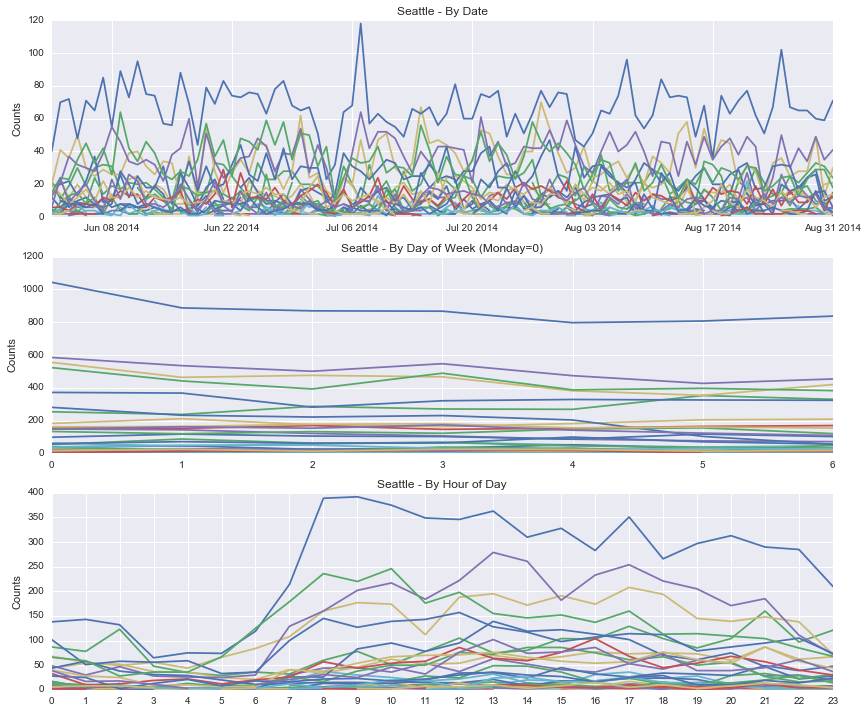

In [7]:
# Plot Seattle crimes by date, day of week and hour of day
fig, ax = plt.subplots(3,1,figsize=(14,12))
for i, table in enumerate([by_date_sea, by_day_sea, by_hr_sea]):
    if i==0:
        ax[i].set_title('Seattle - By Date')
    if i==1:
        ax[i].set_title('Seattle - By Day of Week (Monday=0)')
        plt.xticks(range(24))
    if i==2:
        ax[i].set_title('Seattle - By Hour of Day')
    for col in table.columns:
        table[col].plot(ax=ax[i])
    ax[i].set_ylabel('Counts')

For Seattle we see that like San Francisco, there is one crime that stands out as the most prevalent. Plotting this crime by date shows a jagged up-and-down line suggesting periodicity, but plotting by day of week and hour of day shows much different time occurrence profiles than the top crime in San Francisco. Rather than peaking on weekends it peaks on Mondays and rather than a sharp evening peak followed by a sharp drop-off, the top Seattle crime peaks at 8-9 AM and drops off gradually until 2-3 AM the following day.

### Focus on top five crimes for each city

While meaningful insights might be discovered by digging into the patterns of less frequent crimes, for this analysis we will limit the rest of our inquiry to the top five crimes occurring in each city.

In [8]:
sf_top = sanfran.Descript.value_counts(ascending=False)
sea_top = seattle['Summarized Offense Description'].value_counts(ascending=False)

sf_top5 = sf_top[:5].index
sea_top5 = sea_top[:5].index

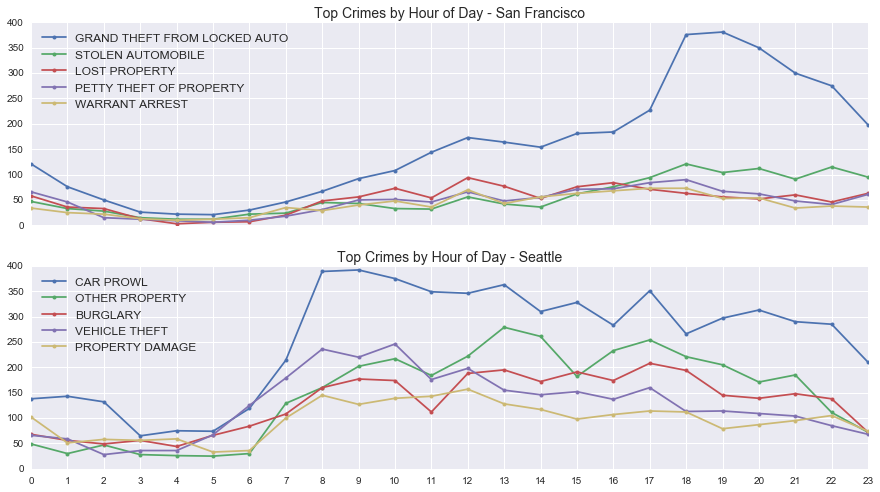

In [9]:
fig, ax = plt.subplots(2,1,sharex=True,figsize=(15,8))
for i, table in enumerate([by_hr_sf, by_hr_sea]):
    top5 = ''
    if i==0:
        top5=sf_top5
        ax[i].set_title('Top Crimes by Hour of Day - San Francisco',fontsize=14)
    else:
        top5=sea_top5
        ax[i].set_title('Top Crimes by Hour of Day - Seattle', fontsize=14)
    for c in top5:
        table[c].plot(ax=ax[i],label=c,marker='o',markersize=4)
    ax[i].legend(loc=2, fontsize=12)
plt.xticks(range(24))
plt.show()

Interestingly we see that the top five crimes for each city follow roughly the same city-specific hourly trajectory, with the similarities being more pronounced in Seattle. We also see that for both cities, two of the top five crimes are vehicle related. It would be worthwhile to investigate how the cities differ in their definition of vehicle related crimes and whether it would be appropriate to aggregate data for any two of them rather than treating them seperately.

Let's see next how the raw incident counts stack up, without regard to time of occurence.

In [10]:
sf_counts = [by_hr_sf[col].sum() for col in sf_top5]
sea_counts = [by_hr_sea[col].sum() for col in sea_top5]

/Users/cathiclose/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


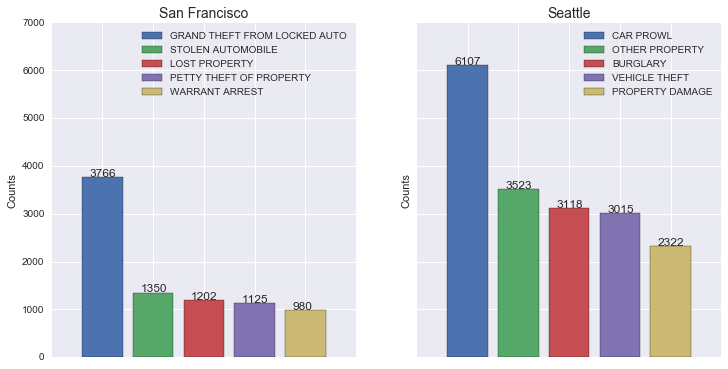

In [11]:
fig, ax = plt.subplots(1,2,sharey=True, figsize=(12,6))
color_cycle = plt.rcParams['axes.color_cycle']
for i, counts in enumerate([sf_counts, sea_counts]):
    labels = ''
    if i==0:
        labels = sf_top5
        ax[i].set_title('San Francisco',fontsize=14)
    else:
        labels = sea_top5
        ax[i].set_title('Seattle',fontsize=14)
    for j in range(5):
        ax[i].bar(j,counts[j],align='center',label=labels[j],color=color_cycle[j])
        ax[i].text(j-.25, 20+counts[j],int(counts[j]))
    ax[i].set_xticks(range(5))
    ax[i].set_xticklabels([])
    ax[i].set_ylabel('Counts')
    ax[i].legend()    
plt.show()

Seattle has greater overall raw counts, as might have been guessed from looking at the previous plots. But how is this picture affected by normalizing for population difference? 2015 population figures were obtained from the following sources:

San Francisco: 864,816	https://en.wikipedia.org/wiki/San_Francisco#Demographics

Seattle:       684,451  https://en.wikipedia.org/wiki/Seattle#Demographics

In [41]:
normd_sf_counts = [round(i/864816,4) for i in sf_counts]
normd_sea_counts = [round(i/684451,4) for i in sea_counts]

(0, 0.01)

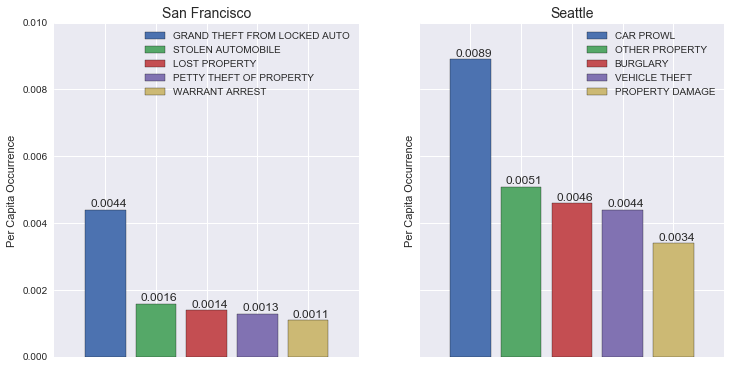

In [42]:
fig, ax = plt.subplots(1,2,sharey=True, figsize=(12,6))
color_cycle = plt.rcParams['axes.color_cycle']
for i, counts in enumerate([normd_sf_counts,normd_sea_counts]):
    labels = ''
    if i==0:
        labels = sf_top5
        ax[i].set_title('San Francisco',fontsize=14)
    else:
        labels = sea_top5
        ax[i].set_title('Seattle',fontsize=14)
    for j in range(5):
        ax[i].bar(j,counts[j],align='center',label=labels[j],color=color_cycle[j])
        ax[i].text(j-.3, .0001+counts[j],counts[j])
    ax[i].set_xticks(range(5))
    ax[i].set_xticklabels([])
    ax[i].set_ylabel('Per Capita Occurrence')
    ax[i].legend()    
plt.ylim((0,.01))

As could be expected, the disparity in raw counts of crime occurrences is amplified by Seattle's smaller population when per capita crime rates are calculated.

# Discussion

In this exploratory analysis, interesting patterns were observed with regard to the time occurrence profiles of common crimes in San Francisco and Seattle. Specifically the top crime in San Francisco (grand theft from locked auto) when plotted by day of week shows an uptick on weekends and when plotted by hour of day shows a dramatic peak in the 6-8 PM period. The top crime in Seattle (car prowl) on the other hand peaks at 8 AM and declines gradually over the next twenty hours. Other common crimes in each city roughly track these hourly distributions.

I am highly skeptical that crimes in the two cities follow such specific schedules. I am inclined to believe that the date-time data provided are subject to sampling error that artificially creates the patterns shown here. For example, more likely than vehicle crimes in San Francisco being clustered in the 6-8 PM window is that this is when people leave work and report crimes that occurred throughout the day without their notice. This same logic could apply the the 8 AM peak observed for Seattle. Other unknown factors such as differences in police reporting practices could have further distorted the data in ways preventing meaningful comparison - at least within the scope of this analysis.

Time occurrences aside, we can at least look to raw incident counts and per capita crime rates to see that Seattle has higher crime on both measures. Here we have taken a snapshot based on the top five crimes in both cities, but if we accept this measure as a crude gauge on the overall crime landscape than Seattle might reasonably be believed to have a significantly worse crime problem than San Francisco. 